In [2]:
import numpy as np
import pandas as pd
from scipy import stats, sparse
import bottleneck

def run_egad(go, nw, **kwargs):
    """EGAD running function
    
    Wrapper to lower level functions for EGAD

    EGAD measures modularity of gene lists in co-expression networks. 

    This was translated from the MATLAB version, which does tiled Cross Validation
    
    The useful kwargs are:
    int - nFold : Number of CV folds to do, default is 3, 
    int - {min,max}_count : limits for number of terms in each gene list, these are exclusive values


    Arguments:
        go {pd.DataFrame} -- dataframe of genes x terms of values [0,1], where 1 is included in gene lists
        nw {pd.DataFrame} -- dataframe of co-expression network, genes x genes
        **kwargs 
    
    Returns:
        pd.DataFrame -- dataframe of terms x metrics where the metrics are 
        ['AUC', 'AVG_NODE_DEGREE', 'DEGREE_NULL_AUC', 'P_Value']
    """
    assert nw.shape[0] == nw.shape[1] , 'Network is not square'
    #print(nw.index)
    #nw.columns = nw.columns.astype(int)
    #print(nw.columns.astype(int))
    assert np.all(nw.index == nw.columns) , 'Network index and columns are not in the same order'

    #nw_mask = nw.isna().sum(axis=1) != nw.shape[1]
    #nw = nw.loc[nw_mask, nw_mask].astype('float')
    #np.fill_diagonal(nw.values, 1)
    return _runNV(go, nw, **kwargs)

def _runNV(go, nw, nFold=3, min_count=20, max_count=1000):

    #Make sure genes are same in go and nw
    #go.index = go.index.map(str) 
    #nw.index = nw.index.map(str)
    #nw.index = nw.index.str.replace('_', '')
    #go.index = go.index.str.replace('_', '')
    #print (nw)
    genes_intersect = go.index.intersection(nw.index)


    #print (genes_intersect)
    go = go.loc[genes_intersect, :]
    nw = nw.loc[genes_intersect, genes_intersect]
    #print (go)
    print (nw.shape)
    print (go.shape)
    sparsity = 1.0 - np.count_nonzero(go) / go.size
    print (sparsity)
    sparsity = 1.0 - np.count_nonzero(nw) / nw.size
    print (sparsity)
    #print(nw
    #print(go
    nw_mask = nw.isna().sum(axis=1) != nw.shape[1]
    nw = nw.loc[nw_mask, nw_mask].astype('float')
    np.fill_diagonal(nw.values, 1)
    #Make sure there aren't duplicates
    duplicates = nw.index.duplicated(keep='first')
    nw = nw.loc[~duplicates, ~duplicates]

    go = go.loc[:, (go.sum(axis=0) > min_count) & (go.sum(axis=0) < max_count)]
    go = go.loc[~go.index.duplicated(keep='first'), :]
    #print(go)

    roc = _new_egad(go.values, nw.values, nFold)

    col_names = ['AUC', 'AVG_NODE_DEGREE', 'DEGREE_NULL_AUC', 'P_Value']
    #Put output in dataframe
    return pd.DataFrame(dict(zip(col_names, roc)), index=go.columns)

def _new_egad(go, nw, nFold):

    #Build Cross validated Positive
    x, y = np.where(go)
    #print(x, y)
    cvgo = {}
    for i in np.arange(nFold):
        a = x[i::nFold]
        #print(a)
        b = y[i::nFold]
        dat = np.ones_like(a)
        mask = sparse.coo_matrix((dat, (a, b)), shape=go.shape)
        cvgo[i] = go - mask.toarray()

    CVgo = np.concatenate(list(cvgo.values()), axis=1)
    #print(CVgo)

    sumin = np.matmul(nw.T, CVgo)

    degree = np.sum(nw, axis=0)
    #print(degree)
    #print(degree[:, None])

    predicts = sumin / degree[:, None]
    #print(predicts)

    np.place(predicts, CVgo > 0, np.nan)

    #print(predicts)

    #Calculate ranks of positives
    rank_abs = lambda x: stats.rankdata(np.abs(x))
    predicts2 = np.apply_along_axis(rank_abs, 0, predicts)
    #print(predicts2)

    #Masking Nans that were ranked (how tiedrank works in matlab)
    predicts2[np.isnan(predicts)] = np.nan
    #print(predicts2)

    filtering = np.tile(go, nFold)
    #print(filtering)

    #negatives :filtering == 0
    #Sets Ranks of negatives to 0
    np.place(predicts2, filtering == 0, 0)

    #Sum of ranks for each prediction
    p = bottleneck.nansum(predicts2, axis=0)
    n_p = np.sum(filtering, axis=0) - np.sum(CVgo, axis=0)

    #Number of negatives
    #Number of GO terms - number of postiive
    n_n = filtering.shape[0] - np.sum(filtering, axis=0)

    roc = (p / n_p - (n_p + 1) / 2) / n_n
    U = roc * n_p * n_n
    Z = (np.abs(U - (n_p * n_n / 2))) / np.sqrt(n_p * n_n *(n_p + n_n + 1) / 12)
    roc = roc.reshape(nFold, go.shape[1])
    Z = Z.reshape(nFold, go.shape[1])
    #Stouffer Z method
    Z = bottleneck.nansum(Z, axis=0) / np.sqrt(nFold)
    #Calc ROC of Neighbor Voting
    roc = bottleneck.nanmean(roc, axis=0)
    P = stats.norm.sf(Z)

    #Average degree for nodes in each go term
    avg_degree = degree.dot(go) / np.sum(go, axis=0)

    #Calc null auc for degree
    ranks = np.tile(stats.rankdata(degree), (go.shape[1], 1)).T

    np.place(ranks, go == 0, 0)

    n_p = bottleneck.nansum(go, axis=0)
    nn = go.shape[0] - n_p
    p = bottleneck.nansum(ranks, axis=0)

    roc_null = (p / n_p - ((n_p + 1) / 2)) / nn
    #print(roc)
    return roc, avg_degree, roc_null, P


In [1]:
!wget http://session.asuscomm.com/database.php

--2022-05-18 21:02:42--  http://session.asuscomm.com/database.php
Resolving session.asuscomm.com (session.asuscomm.com)... 178.55.16.55
Connecting to session.asuscomm.com (session.asuscomm.com)|178.55.16.55|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘database.php’

database.php            [  <=>               ]  49.98K   177KB/s    in 0.3s    

2022-05-18 21:02:42 (177 KB/s) - ‘database.php’ saved [51176]



In [44]:
import pandas as pd
df = pd.read_csv('/grid/gillis/data/lohia/hi_c_data_processing/data_human/scType_marker_genes.csv', header=1, usecols=[0,1,2,3], skipfooter=2)


tissue_type_list = df['Tissue'].drop_duplicates().tolist()

all_gene_list = df['Marker genes'].str.cat(sep=',').split(",")

data_tissue = df.groupby(['Tissue']).apply(lambda grp: grp['Marker genes'].str.cat(sep=',').split(","))

all_gene_list = list(set(all_gene_list))

nested_gene_marker_tissue_list = []

for i in tissue_type_list:
    gene_for_given_tissue = data[data.index ==i][0]
    particular_gene_tissue = [ 1 if x in gene_for_given_tissue else 0 for x in all_gene_list]
    nested_gene_marker_tissue_list.append(particular_gene_tissue)

    

pd.DataFrame(nested_gene_marker_tissue_list, columns = all_gene_list, index=tissue_type_list)

<ipython-input-44-7bb14435cf7b>:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  df = pd.read_csv('/grid/gillis/data/lohia/hi_c_data_processing/data_human/scType_marker_genes.csv', header=1, usecols=[0,1,2,3], skipfooter=2)


In [12]:
import json
import urllib.request
url = "http://session.asuscomm.com/database.php"
x = urllib.request.urlopen(url)
raw_data = x.read()
encoding = x.info().get_content_charset('utf8')  # JSON default
#print(raw_data)   #this is data in string format
data = json.loads(raw_data)
print(data)   #this would be your json data

JSONDecodeError: Expecting value: line 1 column 1 (char 0)

In [145]:
all_gene_list

Gene stable ID Gene name
0      ENSG00000210049     MT-TF
1      ENSG00000211459   MT-RNR1
2      ENSG00000210077     MT-TV
3      ENSG00000210082   MT-RNR2
4      ENSG00000209082    MT-TL1
...                ...       ...
68011  ENSG00000163263   CFAP141
68012  ENSG00000143612   C1orf43
68013  ENSG00000143569    UBAP2L
68014  ENSG00000201129  SNORA58B
68015  ENSG00000143575      HAX1

[68016 rows x 2 columns]

In [155]:
[dict_gene_name_to_ensg[x] if x in dict_gene_name_to_ensg.keys() else 'del' for x in all_gene_list ]

['ENSG00000188612',
 'ENSG00000163331',
 'ENSG00000184302',
 'ENSG00000163631',
 'del',
 'ENSG00000068305',
 'ENSG00000112559',
 'ENSG00000136153',
 'ENSG00000125780',
 'ENSG00000124253',
 'ENSG00000154358',
 'ENSG00000157404',
 'ENSG00000140263',
 'ENSG00000063127',
 'ENSG00000107984',
 'ENSG00000008196',
 'ENSG00000120156',
 'ENSG00000138722',
 'ENSG00000115290',
 'ENSG00000156222',
 'ENSG00000154553',
 'ENSG00000111199',
 'ENSG00000139549',
 'ENSG00000010278',
 'ENSG00000112562',
 'ENSG00000115008',
 'ENSG00000113327',
 'ENSG00000275395',
 'del',
 'ENSG00000154330',
 'ENSG00000136352',
 'ENSG00000134762',
 'ENSG00000180879',
 'ENSG00000130513',
 'ENSG00000125820',
 'del',
 'del',
 'del',
 'ENSG00000112175',
 'del',
 'ENSG00000104921',
 'ENSG00000088386',
 'del',
 'ENSG00000114115',
 'ENSG00000172238',
 'ENSG00000102554',
 'ENSG00000204482',
 'del',
 'ENSG00000187098',
 'ENSG00000107447',
 'ENSG00000163563',
 'del',
 'ENSG00000185010',
 'del',
 'ENSG00000105221',
 'ENSG00000157005',


In [47]:
from hicmatrix import HiCMatrix as hm
from hicmatrix.lib import MatrixFileHandler
SRP_name='aggregates'
resolution='40kbp_raw'
exp_file_path=f'/grid/gillis/data/lohia/hi_c_data_processing/data_mouse/aggregates/40kbp_raw/max/pcc/0/all_bins/KR_KR/hic_gene_corr_gw.h5'

pcc_sim = hm.hiCMatrix(exp_file_path)
all_pcc_genes = [x[3].decode() for x in pcc_sim.cut_intervals]
pcc_sim_matrix = pcc_sim.matrix.toarray()
df_pcc_sim = pd.DataFrame(pcc_sim_matrix,  index=all_pcc_genes, columns = all_pcc_genes)


In [48]:
    pcc_sim_matrix = pcc_sim.matrix.toarray()
    df_pcc_sim = pd.DataFrame(pcc_sim_matrix,  index=all_pcc_genes, columns = all_pcc_genes)

In [139]:
df_2d_pcc = run_egad(go_table_marker, df_pcc_sim )

(92, 92)
(92, 22996)
0.9942792508337934
0.0


In [140]:
df_2d_pcc['AUC'].mean()

0.4710205388227698

In [62]:
df_2d_pcc_marker = run_egad(go_table_marker, df_pcc_sim)

(1621, 1621)
(1621, 22996)
0.9944747250520944
0.0


In [138]:
go_table_marker

GO:0000002  GO:0000003  GO:0000009  GO:0000010  \
NetworkIDs                                                           
ENSMUSG00000001520         0.0         0.0         0.0         0.0   
ENSMUSG00000001988         0.0         1.0         0.0         0.0   
ENSMUSG00000003411         0.0         0.0         0.0         0.0   
ENSMUSG00000003657         0.0         0.0         0.0         0.0   
ENSMUSG00000004366         0.0         0.0         0.0         0.0   
...                        ...         ...         ...         ...   
ENSMUSG00000068859         0.0         0.0         0.0         0.0   
ENSMUSG00000070880         0.0         0.0         0.0         0.0   
ENSMUSG00000075270         0.0         0.0         0.0         0.0   
ENSMUSG00000090063         0.0         0.0         0.0         0.0   
ENSMUSG00000096914         0.0         0.0         0.0         0.0   

                    GO:0000012  GO:0000014  GO:0000015  GO:0000016  \
NetworkIDs                                                           
ENSMUSG00000001520         0.0         0.0         0.0         0.0   
ENSMUSG00000001988         0.0         0.0         0.0         0.0   
ENSMUSG00000003411         0.0         0.0         0.0         0.0   
ENSMUSG00000003657         0.0         0.0         0.0         0.0   
ENSMUSG00000004366         0.0         0.0         0.0         0.0   
...                        ...         ...         ...         ...   
ENSMUSG00000068859         0.0         0.0         0.0         0.0   
ENSMUSG00000070880         0.0         0.0         0.0         0.0   
ENSMUSG00000075270         0.0         0.0         0.0         0.0   
ENSMUSG00000090063         0.0         0.0         0.0         0.0   
ENSMUSG00000096914         0.0         0.0         0.0         0.0   

                    GO:0000017  GO:0000018  ...  GO:2001293  GO:2001294  \
NetworkIDs                                  ...                           
ENSMUSG00000001520         0.0         0.0  ...         0.0         0.0   
ENSMUSG00000001988         0.0         0.0  ...         0.0         0.0   
ENSMUSG00000003411         0.0         0.0  ...         0.0         0.0   
ENSMUSG00000003657         0.0         0.0  ...         0.0         0.0   
ENSMUSG00000004366         0.0         0.0  ...         0.0         0.0   
...                        ...         ...  ...         ...         ...   
ENSMUSG00000068859         0.0         0.0  ...         0.0         0.0   
ENSMUSG00000070880         0.0         0.0  ...         0.0         0.0   
ENSMUSG00000075270         0.0         0.0  ...         0.0         0.0   
ENSMUSG00000090063         0.0         0.0  ...         0.0         0.0   
ENSMUSG00000096914         0.0         0.0  ...         0.0         0.0   

                    GO:2001295  GO:2001300  GO:2001301  GO:2001302  \
NetworkIDs                                                           
ENSMUSG00000001520         0.0         0.0         0.0         0.0   
ENSMUSG00000001988         0.0         0.0         0.0         0.0   
ENSMUSG00000003411         0.0         0.0         0.0         0.0   
ENSMUSG00000003657         0.0         0.0         0.0         0.0   
ENSMUSG00000004366         0.0         0.0         0.0         0.0   
...                        ...         ...         ...         ...   
ENSMUSG00000068859         0.0         0.0         0.0         0.0   
ENSMUSG00000070880         0.0         0.0         0.0         0.0   
ENSMUSG00000075270         0.0         0.0         0.0         0.0   
ENSMUSG00000090063         0.0         0.0         0.0         0.0   
ENSMUSG00000096914         0.0         0.0         0.0         0.0   

                    GO:2001303  GO:2001304  GO:2001306  GO:2001311  
NetworkIDs                                                          
ENSMUSG00000001520         0.0         0.0         0.0         0.0  
ENSMUSG00000001988         0.0         0.0         0.0         0.0  
ENSMUSG00000003411         0.0     

In [75]:
df_2d_pcc_marker['AUC'].mean()

0.5100544514893378

In [66]:
    from hicmatrix import HiCMatrix as hm
    from hicmatrix.lib import MatrixFileHandler
    


    exp_file = hm.hiCMatrix('/grid/gillis/data/lohia/hi_c_data_processing/software/CoCoCoNet/networks/mouse_prioAggNet.h5')
    #chr_list_1 = exp_file.getChrNames()
    
    exp_matrix = exp_file.matrix.toarray()
    exp_genes_all = [x[3].decode() for x in exp_file.cut_intervals]
    df_exp = pd.DataFrame(exp_matrix ,  index=exp_genes_all , columns = exp_genes_all)
    

In [135]:
df_2d = run_egad(go_table_marker, df_exp)

(96, 96)
(96, 22996)
0.9943604322490868
0.0


In [7]:
    df = pd.read_csv(f'/grid/gillis/data/lohia/hi_c_data_processing/software/CoCoCoNet/gene2go/mouse_gene2go.csv', delim_whitespace=True)

    df['val'] = 1

    go_table = pd.pivot_table(df, index=['NetworkIDs'],columns=['GO_term'])

    go_table = go_table.fillna(0)
    
    go_table = pd.DataFrame(go_table.values ,  index=go_table.index , columns = [x[1] for x in go_table.columns])



In [ ]:
from hicmatrix import HiCMatrix as hm
from hicmatrix.lib import MatrixFileHandler
SRP_name='aggregates'
resolution='40kbp_raw'
exp_file_path=f'/grid/gillis/data/lohia/hi_c_data_processing/data_mouse/aggregates/10kbp_raw/max/hic_gene_inter_KR.h5'

jac_sim = hm.hiCMatrix(exp_file_path)
all_genes = [x[3].decode() for x in jac_sim.cut_intervals]
jac_sim_matrix = jac_sim.matrix.toarray()
df_jac_sim = pd.DataFrame(jac_sim_matrix,  index=all_genes, columns = all_genes)
    

In [142]:
df_2d_jac = run_egad(go_table_marker, df_jac_sim)

(92, 92)
(92, 22996)
0.9942792508337934
0.07230623818525517


In [143]:
df_2d_jac['AUC'].mean()

0.5231521483736035

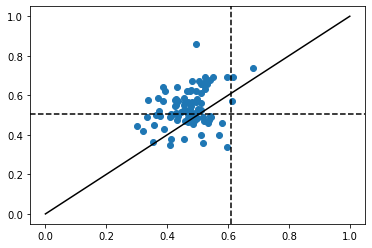

In [141]:
#import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
#plt.plot(data=df_2d, x='AUC', y='DEGREE_NULL_AUC')
plt.scatter(df_2d_pcc['AUC'], df_2d_pcc['DEGREE_NULL_AUC'])
plt.plot([0, 1], [0, 1], c='black')
plt.axvline(x=df_2d['AUC'].mean(),c='black',ls='--')
plt.axhline(y=df_2d['DEGREE_NULL_AUC'].mean(), c='black', ls='--')

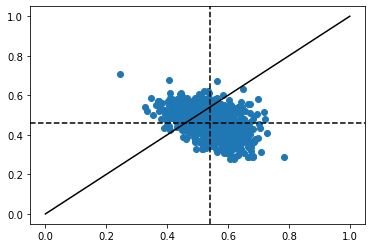

In [71]:
#import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
#plt.plot(data=df_2d, x='AUC', y='DEGREE_NULL_AUC')
plt.scatter(df_2d['AUC'], df_2d['DEGREE_NULL_AUC'])
plt.plot([0, 1], [0, 1], c='black')
plt.axvline(x=df_2d['AUC'].mean(),c='black',ls='--')
plt.axhline(y=df_2d['DEGREE_NULL_AUC'].mean(), c='black', ls='--')

In [10]:
GO_groups = pd.read_csv('/grid/gillis/data/lohia/hi_c_data_processing/genomes_jlee/aug4.GOslim')
df_slim = df_2d[df_2d.index.isin(GO_groups['go_id'].tolist())]

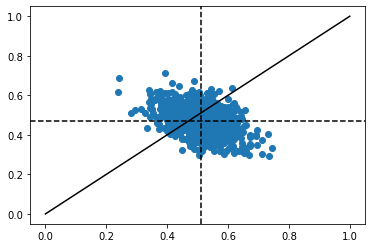

In [64]:
#import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
#plt.plot(data=df_2d_pcc_marker, x='AUC', y='DEGREE_NULL_AUC')
plt.scatter(df_2d_pcc_marker['AUC'], df_2d_pcc_marker['DEGREE_NULL_AUC'])
plt.plot([0, 1], [0, 1], c='black')
plt.axvline(x=df_2d_pcc_marker['AUC'].mean(),c='black',ls='--')
plt.axhline(y=df_2d_pcc_marker['DEGREE_NULL_AUC'].mean(), c='black', ls='--')

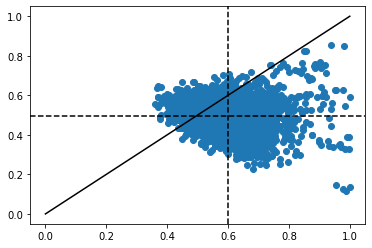

In [26]:
#import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
#plt.plot(data=df_2d, x='AUC', y='DEGREE_NULL_AUC')
plt.scatter(df_2d['AUC'], df_2d['DEGREE_NULL_AUC'])
plt.plot([0, 1], [0, 1], c='black')
plt.axvline(x=df_2d['AUC'].mean(),c='black',ls='--')
plt.axhline(y=df_2d['DEGREE_NULL_AUC'].mean(), c='black', ls='--')

In [21]:
df_2d

AUC  AVG_NODE_DEGREE  DEGREE_NULL_AUC   P_Value
GO:0000002  0.365129        19.603063         0.506772  0.017060
GO:0000018  0.552473        24.237166         0.580585  0.022531
GO:0000027  0.500107        24.461563         0.600900  0.175725
GO:0000028  0.432344        31.498279         0.716399  0.136796
GO:0000030  0.532372        18.921280         0.502340  0.272772
...              ...              ...              ...       ...
GO:2001251  0.499632        23.031182         0.567770  0.293245
GO:2001252  0.499031        21.837483         0.533357  0.094241
GO:2001257  0.522814        18.720278         0.482962  0.150789
GO:2001258  0.457815        18.778835         0.486479  0.036969
GO:2001259  0.539032        18.103287         0.473904  0.114798

[5533 rows x 4 columns]

In [3]:
import seaborn

In [5]:
from hicmatrix import HiCMatrix as hm
from hicmatrix.lib import MatrixFileHandler
SRP_name='aggregates'
resolution='40kbp_raw'
exp_file_path=f'/grid/gillis/data/lohia/hi_c_data_processing/data_mouse/aggregates/40kbp_raw/max/pcc/0/all_bins/KR_KR/hic_gene_corr_gw.h5'

pcc_sim = hm.hiCMatrix(exp_file_path)
all_pcc_genes = [x[3].decode() for x in pcc_sim.cut_intervals]
pcc_sim_matrix = pcc_sim.matrix.toarray()
df_pcc_sim = pd.DataFrame(pcc_sim_matrix,  index=all_pcc_genes, columns = all_pcc_genes)


In [6]:
df_pcc_sim

ENSMUSG00000102693  ENSMUSG00000064842  \
ENSMUSG00000102693            1.000000            0.571257   
ENSMUSG00000064842            0.571257            1.000000   
ENSMUSG00000051951            0.505523            0.519788   
ENSMUSG00000102851            0.638882            0.671924   
ENSMUSG00000103377            0.537295            0.554578   
...                                ...                 ...   
ENSMUSG00000070263           -0.000789           -0.000496   
ENSMUSG00000094649           -0.000789           -0.000496   
ENSMUSG00000069475           -0.000789           -0.000496   
ENSMUSG00000059326           -0.000853           -0.000529   
ENSMUSG00000095993           -0.000940           -0.000626   

                    ENSMUSG00000051951  ENSMUSG00000102851  \
ENSMUSG00000102693            0.505523            0.638882   
ENSMUSG00000064842            0.519788            0.671924   
ENSMUSG00000051951            1.000000            0.611746   
ENSMUSG00000102851            0.611746            1.000000   
ENSMUSG00000103377            0.612794            0.867308   
...                                ...                 ...   
ENSMUSG00000070263           -0.000611           -0.000760   
ENSMUSG00000094649           -0.000611           -0.000760   
ENSMUSG00000069475           -0.000611           -0.000760   
ENSMUSG00000059326           -0.000707           -0.001115   
ENSMUSG00000095993           -0.000704           -0.001000   

                    ENSMUSG00000103377  ENSMUSG00000104017  \
ENSMUSG00000102693            0.537295            0.537295   
ENSMUSG00000064842            0.554578            0.554578   
ENSMUSG00000051951            0.612794            0.612794   
ENSMUSG00000102851            0.867308            0.867308   
ENSMUSG00000103377            1.000000            1.000000   
...                                ...                 ...   
ENSMUSG00000070263           -0.000678           -0.000678   
ENSMUSG00000094649           -0.000678           -0.000678   
ENSMUSG00000069475           -0.000678           -0.000678   
ENSMUSG00000059326           -0.000690           -0.000690   
ENSMUSG00000095993           -0.000806           -0.000806   

                    ENSMUSG00000103025  ENSMUSG00000089699  \
ENSMUSG00000102693            0.442960            0.427662   
ENSMUSG00000064842            0.455776            0.439055   
ENSMUSG00000051951            0.710465            0.734328   
ENSMUSG00000102851            0.779332            0.748751   
ENSMUSG00000103377            0.814532            0.794882   
...                                ...                 ...   
ENSMUSG00000070263           -0.000522           -0.000493   
ENSMUSG00000094649           -0.000522           -0.000493   
ENSMUSG00000069475           -0.000522           -0.000493   
ENSMUSG00000059326           -0.000491           -0.000612   
ENSMUSG00000095993           -0.000655           -0.000598   

                    ENSMUSG00000103201  ENSMUSG00000103147  ...  \
ENSMUSG00000102693            0.416863            0.412963  ...   
ENSMUSG00000064842            0.425240            0.420280  ...   
ENSMUSG00000051951            0.708755            0.714727  ...   
ENSMUSG00000102851            0.741094            0.729829  ...   
ENSMUSG00000103377            0.845449            0.831854  ...   
...                                ...                 ...  ...   
ENSMUSG00000070263           -0.000439           -0.000602  ...   
ENSMUSG00000094649           -0.000439           -0.000602  ...   
ENSMUSG00000069475           -0.000439           -0.000602  ...   
ENSMUSG00000059326           -0.000632           -0.000558  ...   
ENSMUSG00000095993           -0.000574           -0.000606  ...   

                    ENSMUSG00000024997  ENSMUSG00000003228  \
ENSMUSG00000102693           -0.001455           -0.001262   
ENSMUSG00000064842           -0.001193           -0.001049   
ENSMUSG00000051951           -0.001094           

In [26]:
from hicmatrix import HiCMatrix as hm
from hicmatrix.lib import MatrixFileHandler
SRP_name='aggregates'
resolution='40kbp_raw'
exp_file_path=f'/grid/gillis/data/lohia/hi_c_data_processing/data_human/aggregates/100kbp_raw/max/pcc/0/all_bins/KR_KR/hic_gene_corr_gw.h5'

pcc_sim = hm.hiCMatrix(exp_file_path)
all_pcc_genes = [x[3].decode() for x in pcc_sim.cut_intervals]
pcc_sim_matrix_human = pcc_sim.matrix.toarray()
df_pcc_sim_human = pd.DataFrame(pcc_sim_matrix_human,  index=all_pcc_genes, columns = all_pcc_genes)

In [ ]:
ENSG00000119946 - neuron CNNM1 10 
CNR1 - ENSG00000166589 16 
CNTN1 - ENSG00000018236 12 

epithilal cells
RND3 - ENSG00000115963 2
ASS1 - ENSG00000130707 9 
KRT5 -  ENSG00000186081 12 



In [27]:
df_pcc_sim_human['ENSG00000130707']['ENSG00000115963']

-0.0009672968385351642

In [ ]:
import seaborn as sns
#import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
ax = sns.histplot(df_pcc_sim_human)


In [3]:

df_jac_corr = pd.DataFrame(jac_sim.matrix.toarray() ,  index=all_genes, columns = all_genes)

In [4]:
df_jac_corr

ENSMUSG00000102693  ENSMUSG00000064842  \
ENSMUSG00000102693            1.000000            0.571257   
ENSMUSG00000064842            0.571257            1.000000   
ENSMUSG00000051951            0.505523            0.519788   
ENSMUSG00000102851            0.638882            0.671924   
ENSMUSG00000103377            0.537295            0.554578   
...                                ...                 ...   
ENSMUSG00000070263           -0.000789           -0.000496   
ENSMUSG00000094649           -0.000789           -0.000496   
ENSMUSG00000069475           -0.000789           -0.000496   
ENSMUSG00000059326           -0.000853           -0.000529   
ENSMUSG00000095993           -0.000940           -0.000626   

                    ENSMUSG00000051951  ENSMUSG00000102851  \
ENSMUSG00000102693            0.505523            0.638882   
ENSMUSG00000064842            0.519788            0.671924   
ENSMUSG00000051951            1.000000            0.611746   
ENSMUSG00000102851            0.611746            1.000000   
ENSMUSG00000103377            0.612794            0.867308   
...                                ...                 ...   
ENSMUSG00000070263           -0.000611           -0.000760   
ENSMUSG00000094649           -0.000611           -0.000760   
ENSMUSG00000069475           -0.000611           -0.000760   
ENSMUSG00000059326           -0.000707           -0.001115   
ENSMUSG00000095993           -0.000704           -0.001000   

                    ENSMUSG00000103377  ENSMUSG00000104017  \
ENSMUSG00000102693            0.537295            0.537295   
ENSMUSG00000064842            0.554578            0.554578   
ENSMUSG00000051951            0.612794            0.612794   
ENSMUSG00000102851            0.867308            0.867308   
ENSMUSG00000103377            1.000000            1.000000   
...                                ...                 ...   
ENSMUSG00000070263           -0.000678           -0.000678   
ENSMUSG00000094649           -0.000678           -0.000678   
ENSMUSG00000069475           -0.000678           -0.000678   
ENSMUSG00000059326           -0.000690           -0.000690   
ENSMUSG00000095993           -0.000806           -0.000806   

                    ENSMUSG00000103025  ENSMUSG00000089699  \
ENSMUSG00000102693            0.442960            0.427662   
ENSMUSG00000064842            0.455776            0.439055   
ENSMUSG00000051951            0.710465            0.734328   
ENSMUSG00000102851            0.779332            0.748751   
ENSMUSG00000103377            0.814532            0.794882   
...                                ...                 ...   
ENSMUSG00000070263           -0.000522           -0.000493   
ENSMUSG00000094649           -0.000522           -0.000493   
ENSMUSG00000069475           -0.000522           -0.000493   
ENSMUSG00000059326           -0.000491           -0.000612   
ENSMUSG00000095993           -0.000655           -0.000598   

                    ENSMUSG00000103201  ENSMUSG00000103147  ...  \
ENSMUSG00000102693            0.416863            0.412963  ...   
ENSMUSG00000064842            0.425240            0.420280  ...   
ENSMUSG00000051951            0.708755            0.714727  ...   
ENSMUSG00000102851            0.741094            0.729829  ...   
ENSMUSG00000103377            0.845449            0.831854  ...   
...                                ...                 ...  ...   
ENSMUSG00000070263           -0.000439           -0.000602  ...   
ENSMUSG00000094649           -0.000439           -0.000602  ...   
ENSMUSG00000069475           -0.000439           -0.000602  ...   
ENSMUSG00000059326           -0.000632           -0.000558  ...   
ENSMUSG00000095993           -0.000574           -0.000606  ...   

                    ENSMUSG00000024997  ENSMUSG00000003228  \
ENSMUSG00000102693           -0.001455           -0.001262   
ENSMUSG00000064842           -0.001193           -0.001049   
ENSMUSG00000051951           -0.001094           

In [131]:
marker_list = pd.read_csv('/grid/gillis/data/lohia/hi_c_data_processing/notebooks/class_level_markers.csv')
marker_list['gene'] = marker_list['gene'].str.upper()
df_ensg_name = pd.read_csv('/grid/gillis/data/lohia/hi_c_data_processing/genomes_jlee/mouse_geneid_symbol.txt',sep='\t', names=['gene_id', 'gene'])
df_ensg_name['gene'] = df_ensg_name['gene'].str.upper()
marker_list = marker_list.merge(df_ensg_name, right_on='gene', left_on='gene') 

In [132]:
marker_list 

group     cell_type  rank    gene  recurrence     auroc  fold_change  \
0     all     GABAergic     1    GAD1           7  0.941159   116.960472   
1     all     GABAergic     2    GAD2           7  0.928440   139.811415   
2     all     GABAergic     3   ERBB4           7  0.921449    81.717383   
3     all     GABAergic     4  KCNIP1           7  0.916919    32.252038   
4     all     GABAergic     5   RBMS3           7  0.902093    17.038869   
..    ...           ...   ...     ...         ...       ...          ...   
294   all  Non-Neuronal    96     MAG           6  0.648512   165.820081   
295   all  Non-Neuronal    97   FNBP1           6  0.648028     5.592886   
296   all  Non-Neuronal    98  FRMD4B           6  0.647805     9.050547   
297   all  Non-Neuronal    99    PLLP           6  0.645540    61.884548   
298   all  Non-Neuronal   100   PRR5L           6  0.645414   187.906185   

     fold_change_detection   expression  precision  ...  population_size  \
0                 9.289078   820.463486   0.659089  ...     10207.000000   
1                13.987046   659.151566   0.730005  ...     10207.000000   
2                 5.736415  2257.167753   0.514809  ...     10207.000000   
3                10.796420   588.571993   0.687830  ...     10207.000000   
4                 3.607831   340.701798   0.442861  ...     10207.000000   
..                     ...          ...        ...  ...              ...   
294              16.747920   456.955370   0.370001  ...      8908.857143   
295               0.955553   454.931925   0.063414  ...      8908.857143   
296               2.335387   192.151003   0.124702  ...      8908.857143   
297              12.642643   190.039132   0.314672  ...      8908.857143   
298              30.603359   334.996404   0.447383  ...      8908.857143   

     n_datasets   scSS  snSS  scCv2  snCv2  snCv3M  scCv3  snCv3Z  \
0             7   True  True   True   True    True   True    True   
1             7   True  True   True   True    True   True    True   
2             7   True  True   True   True    True   True    True   
3             7   True  True   True   True    True   True    True   
4             7   True  True   True   True    True   True    True   
..          ...    ...   ...    ...    ...     ...    ...     ...   
294           7  False  True   True   True    True   True    True   
295           7  False  True   True   True    True   True    True   
296           7  False  True   True   True    True   True    True   
297           7  False  True   True   True    True   True    True   
298           7  False  True   True   True    True   True    True   

                gene_id  
0    ENSMUSG00000070880  
1    ENSMUSG00000026787  
2    ENSMUSG00000062209  
3    ENSMUSG00000053519  
4    ENSMUSG00000039607  
..                  ...  
294  ENSMUSG00000036634  
295  ENSMUSG00000075415  
296  ENSMUSG00000030064  
297  ENSMUSG00000031775  
298  ENSMUSG00000032841  

[299 rows x 21 columns]

In [30]:
marker_list = marker_list.merge(df_ensg_name, right_on='gene', left_on='gene') 

In [133]:
marker_gene_list = marker_list[marker_list['cell_type']=='GABAergic']['gene_id'].to_list()

In [134]:
go_table_marker = go_table[go_table.index.isin(marker_gene_list)]

In [130]:
marker_list.pivot(index='gene_id', columns='cell_type', values='rank')

cell_type           Astro  Endo  L2/3 IT  L4/5 IT  L5 IT  L5 PT  L5/6 NP  \
gene_id                                                                    
ENSMUSG00000000093    NaN   NaN      NaN      NaN    NaN    NaN      NaN   
ENSMUSG00000000126    NaN   NaN      NaN     93.0    NaN    NaN      NaN   
ENSMUSG00000000202   80.0   NaN      NaN      NaN    NaN    NaN      NaN   
ENSMUSG00000000305    NaN   NaN      NaN      NaN    NaN    NaN      NaN   
ENSMUSG00000000392    NaN   NaN      NaN      NaN    NaN    NaN      NaN   
...                   ...   ...      ...      ...    ...    ...      ...   
ENSMUSG00000116022    NaN   NaN      NaN      NaN    NaN    NaN      NaN   
ENSMUSG00000116076    NaN   NaN      NaN      NaN    NaN    NaN      NaN   
ENSMUSG00000116258    NaN   NaN      NaN      NaN    NaN    NaN      NaN   
ENSMUSG00000116470    NaN   NaN      NaN      NaN    NaN    NaN      NaN   
ENSMUSG00000116510    NaN   NaN      NaN      NaN    NaN    NaN      NaN   

cell_type           L6 CT  L6 IT  L6 IT Car3  ...  Micro-PVM  Oligo  Peri  \
gene_id                                       ...                           
ENSMUSG00000000093    NaN    NaN         NaN  ...        NaN    NaN   NaN   
ENSMUSG00000000126    NaN    NaN         NaN  ...        NaN    NaN   NaN   
ENSMUSG00000000202    NaN    NaN         NaN  ...        NaN    NaN   NaN   
ENSMUSG00000000305    NaN   72.0         NaN  ...        NaN    NaN   NaN   
ENSMUSG00000000392    NaN    NaN        21.0  ...        NaN    NaN   NaN   
...                   ...    ...         ...  ...        ...    ...   ...   
ENSMUSG00000116022    NaN    NaN        95.0  ...        NaN    NaN   NaN   
ENSMUSG00000116076    NaN    NaN         NaN  ...        NaN    NaN   NaN   
ENSMUSG00000116258    NaN    NaN         NaN  ...       67.0    NaN   NaN   
ENSMUSG00000116470    NaN    NaN         NaN  ...       27.0    NaN   NaN   
ENSMUSG00000116510    NaN    NaN         NaN  ...        NaN    NaN   NaN   

cell_type           Pvalb   SMC  Sncg  Sst  Sst Chodl  VLMC  Vip  
gene_id                                                           
ENSMUSG00000000093    NaN  96.0   NaN  NaN        NaN   NaN  NaN  
ENSMUSG00000000126    NaN   NaN   NaN  NaN        NaN   NaN  NaN  
ENSMUSG00000000202    NaN   NaN   NaN  NaN        NaN   NaN  NaN  
ENSMUSG00000000305    NaN   NaN   NaN  NaN        NaN   NaN  NaN  
ENSMUSG00000000392    NaN   NaN   NaN  NaN        NaN   NaN  NaN  
...                   ...   ...   ...  ...        ...   ...  ...  
ENSMUSG00000116022    NaN   NaN   NaN  NaN        NaN   NaN  NaN  
ENSMUSG00000116076    NaN   NaN   NaN  NaN        NaN   NaN  NaN  
ENSMUSG00000116258    NaN   NaN   NaN  NaN        NaN   NaN  NaN  
ENSMUSG00000116470    NaN   NaN   NaN  NaN        NaN   NaN  NaN  
ENSMUSG00000116510    NaN   NaN   NaN  NaN        NaN  49.0  NaN  

[1748 rows x 23 columns]

In [33]:
marker_table = marker_list.pivot(index='gene_id', columns='cell_type', values='rank')

In [38]:
marker_table.fillna(0, inplace=True)

In [127]:
marker_list['gene_2'] = marker_list['gene_id']

In [93]:
marker_table

cell_type           Astro  Endo  L2/3 IT  L4/5 IT  L5 IT  L5 PT  L5/6 NP  \
gene_id                                                                    
ENSMUSG00000000093    0.0   0.0      0.0      0.0    0.0    0.0      0.0   
ENSMUSG00000000126    0.0   0.0      0.0      1.0    0.0    0.0      0.0   
ENSMUSG00000000202    1.0   0.0      0.0      0.0    0.0    0.0      0.0   
ENSMUSG00000000305    0.0   0.0      0.0      0.0    0.0    0.0      0.0   
ENSMUSG00000000392    0.0   0.0      0.0      0.0    0.0    0.0      0.0   
...                   ...   ...      ...      ...    ...    ...      ...   
ENSMUSG00000116022    0.0   0.0      0.0      0.0    0.0    0.0      0.0   
ENSMUSG00000116076    0.0   0.0      0.0      0.0    0.0    0.0      0.0   
ENSMUSG00000116258    0.0   0.0      0.0      0.0    0.0    0.0      0.0   
ENSMUSG00000116470    0.0   0.0      0.0      0.0    0.0    0.0      0.0   
ENSMUSG00000116510    0.0   0.0      0.0      0.0    0.0    0.0      0.0   

cell_type           L6 CT  L6 IT  L6 IT Car3  ...  Micro-PVM  Oligo  Peri  \
gene_id                                       ...                           
ENSMUSG00000000093    0.0    0.0         0.0  ...        0.0    0.0   0.0   
ENSMUSG00000000126    0.0    0.0         0.0  ...        0.0    0.0   0.0   
ENSMUSG00000000202    0.0    0.0         0.0  ...        0.0    0.0   0.0   
ENSMUSG00000000305    0.0    1.0         0.0  ...        0.0    0.0   0.0   
ENSMUSG00000000392    0.0    0.0         1.0  ...        0.0    0.0   0.0   
...                   ...    ...         ...  ...        ...    ...   ...   
ENSMUSG00000116022    0.0    0.0         1.0  ...        0.0    0.0   0.0   
ENSMUSG00000116076    0.0    0.0         0.0  ...        0.0    0.0   0.0   
ENSMUSG00000116258    0.0    0.0         0.0  ...        1.0    0.0   0.0   
ENSMUSG00000116470    0.0    0.0         0.0  ...        1.0    0.0   0.0   
ENSMUSG00000116510    0.0    0.0         0.0  ...        0.0    0.0   0.0   

cell_type           Pvalb  SMC  Sncg  Sst  Sst Chodl  VLMC  Vip  
gene_id                                                          
ENSMUSG00000000093    0.0  1.0   0.0  0.0        0.0   0.0  0.0  
ENSMUSG00000000126    0.0  0.0   0.0  0.0        0.0   0.0  0.0  
ENSMUSG00000000202    0.0  0.0   0.0  0.0        0.0   0.0  0.0  
ENSMUSG00000000305    0.0  0.0   0.0  0.0        0.0   0.0  0.0  
ENSMUSG00000000392    0.0  0.0   0.0  0.0        0.0   0.0  0.0  
...                   ...  ...   ...  ...        ...   ...  ...  
ENSMUSG00000116022    0.0  0.0   0.0  0.0        0.0   0.0  0.0  
ENSMUSG00000116076    0.0  0.0   0.0  0.0        0.0   0.0  0.0  
ENSMUSG00000116258    0.0  0.0   0.0  0.0        0.0   0.0  0.0  
ENSMUSG00000116470    0.0  0.0   0.0  0.0        0.0   0.0  0.0  
ENSMUSG00000116510    0.0  0.0   0.0  0.0        0.0   1.0  0.0  

[1748 rows x 23 columns]

In [98]:
marker_table.sum(axis=1).max()

4.0

In [39]:
marker_table[marker_table != 0] = 1

In [42]:
df_2d_marker = run_egad(marker_table, df_jac_sim)

(1686, 1686)
(1686, 23)
0.9434473154881634
0.00015267734141610756


In [102]:
import seaborn as sns

ModuleNotFoundError: No module named 'seaborn'

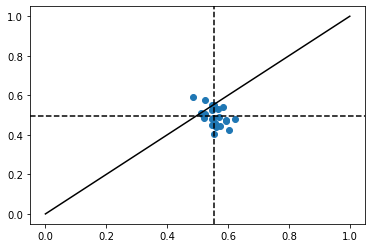

In [45]:
#import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
#plt.plot(data=df_2d_marker, x='AUC', y='DEGREE_NULL_AUC')
plt.scatter(df_2d_marker['AUC'], df_2d_marker['DEGREE_NULL_AUC'])
plt.plot([0, 1], [0, 1], c='black')
plt.axvline(x=df_2d_marker['AUC'].mean(),c='black',ls='--')
plt.axhline(y=df_2d_marker['DEGREE_NULL_AUC'].mean(), c='black', ls='--')

In [50]:
df_2d_pcc

AUC  AVG_NODE_DEGREE  DEGREE_NULL_AUC   P_Value
cell_type                                                       
Astro       0.503210         1.913791         0.478775  0.391881
Endo        0.515818         2.170890         0.574170  0.296932
L2/3 IT     0.521518         1.774665         0.424600  0.161082
L4/5 IT     0.544023         1.944930         0.503752  0.068288
L5 IT       0.623693         1.917719         0.488662  0.000173
L5 PT       0.505324         2.007771         0.522082  0.010282
L5/6 NP     0.481446         1.958254         0.493898  0.193746
L6 CT       0.530166         1.927822         0.486792  0.164214
L6 IT       0.527801         1.974229         0.513981  0.172077
L6 IT Car3  0.594622         1.767828         0.429782  0.000774
L6b         0.594225         2.099337         0.536406  0.001011
Lamp5       0.544632         1.842110         0.450468  0.014267
Meis2       0.572895         1.788634         0.424824  0.007227
Micro-PVM   0.483450         2.146425         0.558534  0.173389
Oligo       0.447767         2.050176         0.527428  0.041854
Peri        0.482623         2.131128         0.561921  0.069004
Pvalb       0.491573         1.997302         0.509245  0.350954
SMC         0.537113         2.071364         0.536003  0.105072
Sncg        0.538548         1.833858         0.462546  0.098128
Sst         0.637208         1.852387         0.447168  0.000003
Sst Chodl   0.571757         1.904202         0.476954  0.006663
VLMC        0.514868         1.818941         0.443888  0.314480
Vip         0.536460         1.886273         0.484717  0.116352

ENSMUSG00000102693  ENSMUSG00000064842  \
ENSMUSG00000025902            0.000000            0.000000   
ENSMUSG00000002459            0.000000            0.000000   
ENSMUSG00000025905            0.000000            0.000000   
ENSMUSG00000033774            0.000000            0.000000   
ENSMUSG00000033740            0.000000            0.000000   
...                                ...                 ...   
ENSMUSG00000033717            0.366166            0.229627   
ENSMUSG00000025085            1.365559            1.478565   
ENSMUSG00000025089            1.269398            1.589114   
ENSMUSG00000087095            0.574653            0.623493   
ENSMUSG00000043969            0.000000            0.000000   

                    ENSMUSG00000051951  ENSMUSG00000102851  \
ENSMUSG00000025902            0.000000            0.000000   
ENSMUSG00000002459            0.000000            0.000000   
ENSMUSG00000025905            0.000000            0.000000   
ENSMUSG00000033774            0.000000            0.000000   
ENSMUSG00000033740            0.000000            0.000000   
...                                ...                 ...   
ENSMUSG00000033717            1.178969            0.000000   
ENSMUSG00000025085            2.491248            1.060422   
ENSMUSG00000025089            2.359633            1.141312   
ENSMUSG00000087095            1.837031            0.852265   
ENSMUSG00000043969            1.684755            0.236173   

                    ENSMUSG00000103377  ENSMUSG00000104017  \
ENSMUSG00000025902            0.000000            0.000000   
ENSMUSG00000002459            0.000000            0.000000   
ENSMUSG00000025905            0.000000            0.000000   
ENSMUSG00000033774            0.000000            0.000000   
ENSMUSG00000033740            0.000000            0.000000   
...                                ...                 ...   
ENSMUSG00000033717            0.918616            0.000000   
ENSMUSG00000025085            1.503066            1.024828   
ENSMUSG00000025089            2.194195            1.022159   
ENSMUSG00000087095            0.829431            1.394088   
ENSMUSG00000043969            0.829431            1.379740   

                    ENSMUSG00000103025  ENSMUSG00000089699  \
ENSMUSG00000025902            0.000000            0.000000   
ENSMUSG00000002459            0.000000            0.000000   
ENSMUSG00000025905            0.000000            0.000000   
ENSMUSG00000033774            0.000000            0.000000   
ENSMUSG00000033740            0.000000            0.000000   
...                                ...                 ...   
ENSMUSG00000033717            0.184168            0.829170   
ENSMUSG00000025085            1.015793            2.491248   
ENSMUSG00000025089            1.363394            2.028171   
ENSMUSG00000087095            0.623578            1.044095   
ENSMUSG00000043969            0.915374            0.935836   

                    ENSMUSG00000103201  ENSMUSG00000103147  ...  non-gene  \
ENSMUSG00000025902            0.000000            0.000000  ...       0.0   
ENSMUSG00000002459            0.000000            0.000000  ...       0.0   
ENSMUSG00000025905            0.000000            0.000000  ...       0.0   
ENSMUSG00000033774            0.000000            0.000000  ...       0.0   
ENSMUSG00000033740            0.000000            0.000000  ...       0.0   
...                                ...                 ...  ...       ...   
ENSMUSG00000033717            0.495507            0.624326  ...       0.0   
ENSMUSG00000025085            2.243846            1.349966  ...       0.0   
ENSMUSG00000025089            2.028171            1.242715  ...       0.0   
ENSMUSG00000087095            0.559250            0.847598  ...       0.0   
ENSMUSG00000043969            0.559250            0.258592  ...       0.0   

                    non-gene  non-gene  non-gene  non-gene  non-gene  \
ENSMUSG00000025902       0.0       0.0     

In [84]:
df_jac_sim

ENSMUSG00000102693  ENSMUSG00000064842  \
ENSMUSG00000102693                 0.0                 0.0   
ENSMUSG00000064842                 0.0                 0.0   
ENSMUSG00000051951                 0.0                 0.0   
ENSMUSG00000102851                 0.0                 0.0   
ENSMUSG00000103377                 0.0                 0.0   
...                                ...                 ...   
non-gene                           0.0                 0.0   
non-gene                           0.0                 0.0   
non-gene                           0.0                 0.0   
non-gene                           0.0                 0.0   
non-gene                           0.0                 0.0   

                    ENSMUSG00000051951  ENSMUSG00000102851  \
ENSMUSG00000102693                 0.0                 0.0   
ENSMUSG00000064842                 0.0                 0.0   
ENSMUSG00000051951                 0.0                 0.0   
ENSMUSG00000102851                 0.0                 0.0   
ENSMUSG00000103377                 0.0                 0.0   
...                                ...                 ...   
non-gene                           0.0                 0.0   
non-gene                           0.0                 0.0   
non-gene                           0.0                 0.0   
non-gene                           0.0                 0.0   
non-gene                           0.0                 0.0   

                    ENSMUSG00000103377  ENSMUSG00000104017  \
ENSMUSG00000102693                 0.0                 0.0   
ENSMUSG00000064842                 0.0                 0.0   
ENSMUSG00000051951                 0.0                 0.0   
ENSMUSG00000102851                 0.0                 0.0   
ENSMUSG00000103377                 0.0                 0.0   
...                                ...                 ...   
non-gene                           0.0                 0.0   
non-gene                           0.0                 0.0   
non-gene                           0.0                 0.0   
non-gene                           0.0                 0.0   
non-gene                           0.0                 0.0   

                    ENSMUSG00000103025  ENSMUSG00000089699  \
ENSMUSG00000102693                 0.0                 0.0   
ENSMUSG00000064842                 0.0                 0.0   
ENSMUSG00000051951                 0.0                 0.0   
ENSMUSG00000102851                 0.0                 0.0   
ENSMUSG00000103377                 0.0                 0.0   
...                                ...                 ...   
non-gene                           0.0                 0.0   
non-gene                           0.0                 0.0   
non-gene                           0.0                 0.0   
non-gene                           0.0                 0.0   
non-gene                           0.0                 0.0   

                    ENSMUSG00000103201  ENSMUSG00000103147  ...  non-gene  \
ENSMUSG00000102693                 0.0                 0.0  ...       0.0   
ENSMUSG00000064842                 0.0                 0.0  ...       0.0   
ENSMUSG00000051951                 0.0                 0.0  ...       0.0   
ENSMUSG00000102851                 0.0                 0.0  ...       0.0   
ENSMUSG00000103377                 0.0                 0.0  ...       0.0   
...                                ...                 ...  ...       ...   
non-gene                           0.0                 0.0  ...       0.0   
non-gene                           0.0                 0.0  ...       0.0   
non-gene                           0.0                 0.0  ...       0.0   
non-gene                           0.0                 0.0  ...       0.0   
non-gene                           0.0                 0.0  ...       0.0   

                    non-gene  non-gene  non-gene  non-gene  non-gene  \
ENSMUSG00000102693       0.0       0.0     

In [88]:
df_jac_sim_subset_matrix = df_jac_sim[df_jac_sim.index.isin(marker_table.index)]
df_jac_sim_subset_genes =  df_jac_sim_subset_matrix.index.tolist()

In [ ]:
import h5py
import logging
import numpy as np
import pandas as pd
from hicmatrix import HiCMatrix as hm
from hicmatrix.lib import MatrixFileHandler
from scipy.sparse import csr_matrix, dia_matrix, triu, tril, coo_matrix
import scipy.stats as stats
import os.path

    
def calc_auc(exp_file, jac_sim, outfile, auc_type, given_top_percentile=1 ,jac_sim_species='a', exp_file_species='a', ortho_genes="ortho_genes"):
    
        exp_genes_all = [x[3].decode() for x in exp_file.cut_intervals]
        exp_matrix = exp_file.matrix
        
        
        all_genes_all = [x[3].decode() for x in jac_sim.cut_intervals]
        
        entire_matrix = jac_sim.matrix
        entire_matrix = entire_matrix.astype('float32')
        
        
    
        if jac_sim_species != exp_file_species:
            df_1_1 = pd.read_csv(ortho_genes)
            df_1_1 = df_1_1.drop_duplicates(subset=[jac_sim_species], keep=False)
            df_1_1 = df_1_1.drop_duplicates(subset=[exp_file_species], keep=False)
            jac_sim_species_ortho_subset = list (set(all_genes_all) & set(df_1_1[jac_sim_species].tolist()))
            df_1_1 = df_1_1[df_1_1[jac_sim_species].isin(jac_sim_species_ortho_subset)]
            exp_file_species_ortho_subset = list (set(exp_genes_all) & set(df_1_1[exp_file_species].tolist()))
            df_1_1 = df_1_1[df_1_1[exp_file_species].isin(exp_file_species_ortho_subset)]
            subset_genes_exp_file = df_1_1[exp_file_species].tolist()
            subset_genes_jac_sim = df_1_1[jac_sim_species].tolist()
            
        else:
            subset_genes_exp_file = list (set(all_genes_all) & set(exp_genes_all))
            subset_genes_jac_sim  = list (set(all_genes_all) & set(exp_genes_all))
            
        exp_genes_index_list = [i for i, value in enumerate(exp_genes_all) if value in subset_genes_exp_file]
        exp_genes = [value for i, value in enumerate(exp_genes_all) if value in subset_genes_exp_file]
        exp_matrix  = csr_matrix(exp_matrix)[exp_genes_index_list, :][:, exp_genes_index_list]
        
        updated_cut_intervals = [exp_file.cut_intervals[x] for x in exp_genes_index_list]
        exp_file.update_matrix(exp_matrix,  updated_cut_intervals)
   
        exp_matrix = exp_matrix.toarray()
    
        

        rank_abs = lambda x: stats.rankdata(x, method='ordinal')
        exp_matrix = np.apply_along_axis(rank_abs, 1, exp_matrix)
        
        exp_matrix = exp_matrix * 1.0
        
        exp_matrix = exp_matrix.astype('float32')
        
        
        
        
        chr_list_2 = exp_file.getChrNames()

        
        all_gene_index_list = [i for i, value in enumerate(all_genes_all) if value in subset_genes_jac_sim]
        all_genes = [value for i, value in enumerate(all_genes_all) if value in subset_genes_jac_sim]
        
        entire_matrix  = csr_matrix(entire_matrix)[all_gene_index_list, :][:, all_gene_index_list]
        
        updated_cut_intervals = [jac_sim.cut_intervals[x] for x in all_gene_index_list]
        jac_sim.update_matrix(entire_matrix, updated_cut_intervals)
        
        entire_matrix = entire_matrix.toarray()
        entire_matrix = entire_matrix.astype('float32')
        
        chr_list_1 = jac_sim.getChrNames()

        max_value = entire_matrix.max() + 1 + exp_matrix.max()
        max_value = max_value.astype('float32')

        if auc_type == 'inter_only':
        
            for chrom in chr_list_1:

                start, end = jac_sim.getChrBinRange(chrom)
                
                entire_matrix[start: end, start: end] = max_value 
                

                

                
        
        elif auc_type == 'intra_only':


            for chrom in chr_list_2:

                start, end = exp_file.getChrBinRange(chrom)
                
                coordinate_matrix[start: end, start: end] = max_value
                
            inter_coodinates = np.where(coordinate_matrix != max_value)
            x_inter = inter_coodinates[0].tolist()
            y_inter = inter_coodinates[1].tolist()
            exp_matrix[x_inter, y_inter] = max_value
            np.fill_diagonal(exp_matrix , max_value)
            #exp_matrix.setdiag(max_value, k=0)


        else:

            np.fill_diagonal(entire_matrix , max_value)

            np.fill_diagonal(exp_matrix , max_value)
            #exp_matrix.setdiag(max_value, k=0)
            #entire_matrix.setdiag(max_value, k=0)


        df_jac = pd.DataFrame(entire_matrix ,  index=all_genes, columns = all_genes)
        df_exp = pd.DataFrame(exp_matrix ,  index=exp_genes, columns = exp_genes)


            df_jac_subset = df_jac.loc[subset_genes_jac_sim, subset_genes_jac_sim]


        coodinates_1 = np.where(df_jac_subset == max_value)


        x_coo = coodinates_1[0].tolist()
        y_coo = coodinates_1[1].tolist() 

        df_jac_subset.to_numpy()[x_coo, y_coo] = max_value


            
        rank_abs = lambda x: stats.rankdata(x)
        predicts2 = np.apply_along_axis(rank_abs, 1, df_jac_subset)
        predicts2 = predicts2.astype('float')
        
        predicts2[x_coo, y_coo] = np.nan
        
        top_percentile = 100 - given_top_percentile
                
        exp_upper = lambda x: np.where(x < np.percentile(x[~np.isnan(x)] , top_percentile), 0, 1.0) if x[~np.isnan(x)].shape[0] > 0 else np.zeros(x.shape[0])
        tp = np.apply_along_axis(exp_upper, 1, df_exp_subset)
        tp[x_coo, y_coo] = np.nan
        exp_upper = lambda x: np.where(x >= np.percentile(x[~np.isnan(x)] , top_percentile), 0, 1.0) if x[~np.isnan(x)].shape[0] > 0 else np.zeros(x.shape[0])
        tn = np.apply_along_axis(exp_upper, 1, df_exp_subset)
        tn[x_coo, y_coo] = np.nan
        pos_rank_sum = tp * predicts2
        auc_array = (((np.nansum(pos_rank_sum, axis=1) / (np.nansum(tp, axis=1)) )- (np.nansum(tp, axis=1) + 1)/2)) / np.nansum(tn, axis=1)
        
        df = pd.DataFrame(columns = ['gene_id_jac_sim', 'chrom_jac_sim', 'gene_id_exp_file', 'chrom_exp_file', 'auc'])  
        df['auc'] = auc_array.tolist()
        df['gene_id_exp_file'] = subset_genes_exp_file
        df['gene_id_jac_sim'] = subset_genes_jac_sim
        
        gene_list = [x[3].decode() for x in jac_sim.cut_intervals]
        _chrom_list = [x[0] for x in jac_sim.cut_intervals]
        df['chrom_jac_sim'] = [_chrom_list[gene_list.index(x)] for x in df['gene_id_jac_sim']]

        gene_list = [x[3].decode() for x in exp_file.cut_intervals]
        _chrom_list = [x[0] for x in exp_file.cut_intervals]
        df['chrom_exp_file'] = [_chrom_list[gene_list.index(x)] for x in df['gene_id_exp_file']]
        df.to_csv(outfile, sep='\t', index=False)
        
        
if __name__ == '__main__':

    
    import argparse
    parser = argparse.ArgumentParser()

    parser.add_argument('--outfile', default='tss',
                            help='tss or tss_max')
    parser.add_argument('--exp_file_path', default='tss',
                            help='tss or tss_max')
    parser.add_argument('--jac_sim_path', default='tss',
                            help='tss or tss_max')
    parser.add_argument('--auc_type', default='intra_only',
                            help='tss or tss_max')
    parser.add_argument('--jac_sim_species', default='a',
                            help='tss or tss_max')
    parser.add_argument('--exp_file_species', default='a',
                            help='tss or tss_max')
    parser.add_argument('--ortho_genes', default='b',
                            help='tss or tss_max')
    parser.add_argument('--given_top_percentile', default=1,
                            help='tss or tss_max')
    


    args = parser.parse_args()
    
    if not os.path.isfile(args.outfile):

    
        jac_sim = hm.hiCMatrix(args.jac_sim_path)
        exp_file = hm.hiCMatrix(args.exp_file_path)

        print (args.jac_sim_path)
        print (args.exp_file_path)

        calc_auc(exp_file, jac_sim, args.outfile, args.auc_type, given_top_percentile=int(args.given_top_percentile), jac_sim_species=args.jac_sim_species, exp_file_species=args.exp_file_species, ortho_genes=args.ortho_genes)


In [117]:
from umap import UMAP
#import plotly.express as px
reducer = UMAP(n_components=2, init='random', random_state=0)

ImportError: cannot import name 'UMAP' from 'umap' (/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/umap/__init__.py)

In [122]:
marker_list[['gene_id', 'cell_type']]

group cell_type  rank      gene  recurrence     auroc  \
0     Non-Neuronal     Astro     1    SLC1A2           6  0.995769   
1     Non-Neuronal     Astro     2       NTM           6  0.978977   
2     Non-Neuronal     Astro     3    SLC1A3           6  0.972470   
3     Non-Neuronal     Astro     4    GABRB1           6  0.958026   
4     Non-Neuronal     Astro     5    TSPAN7           6  0.956186   
...            ...       ...   ...       ...         ...       ...   
2263  Non-Neuronal      VLMC    95   GM30624           2  0.631826   
2264  Non-Neuronal      VLMC    96  SH3PXD2A           2  0.630981   
2265  Non-Neuronal      VLMC    97       NXN           2  0.629492   
2266  Non-Neuronal      VLMC    98     PRDM6           2  0.625416   
2267  Non-Neuronal      VLMC   100     SNED1           2  0.613429   

      fold_change  fold_change_detection   expression  precision  ...  \
0       79.327970               3.925241  6011.876920   0.627385  ...   
1       18.671875               3.094278  3039.715310   0.591128  ...   
2       16.164421               3.715663  3039.491778   0.620450  ...   
3       48.232032               5.003564  1849.913350   0.683010  ...   
4       12.682771               2.162795  2402.956782   0.507171  ...   
...           ...                    ...          ...        ...  ...   
2263    17.677736               9.874028     0.000000   0.384595  ...   
2264     2.410348               2.116879     0.000000   0.127298  ...   
2265     0.582957               0.256502     0.000000   0.054695  ...   
2266    13.189692              12.174497     0.000000        NaN  ...   
2267     1.294267               0.901668     0.000000        NaN  ...   

      population_size  n_datasets   scSS  snSS  scCv2  snCv2 snCv3M  scCv3  \
0         2775.142857           7  False  True   True   True   True   True   
1         2775.142857           7  False  True   True   True   True   True   
2         2775.142857           7  False  True   True   True   True   True   
3         2775.142857           7  False  True   True   True   True   True   
4         2775.142857           7  False  True   True   True   True   True   
...               ...         ...    ...   ...    ...    ...    ...    ...   
2263       473.000000           5  False   NaN   True  False   True    NaN   
2264       473.000000           5  False   NaN  False  False   True    NaN   
2265       473.000000           5  False   NaN  False  False   True    NaN   
2266       473.000000           5  False   NaN  False  False   True    NaN   
2267       473.000000           5  False   NaN  False  False   True    NaN   

     snCv3Z             gene_id  
0      True  ENSMUSG00000005089  
1      True  ENSMUSG00000059974  
2      True  ENSMUSG00000005360  
3      True  ENSMUSG00000029212  
4      True  ENSMUSG00000058254  
...     ...                 ...  
2263  False  ENSMUSG00000112430  
2264   True  ENSMUSG00000053617  
2265   True  ENSMUSG00000020844  
2266   True  ENSMUSG00000069378  
2267   True  ENSMUSG00000047793  

[2268 rows x 21 columns]

In [124]:
df_pcc_sim.merge(marker_list[['gene_id', 'cell_type']], left_on=df_pcc_sim.index, right_on='gene_id')

ENSMUSG00000102693  ENSMUSG00000064842  ENSMUSG00000051951  \
0               0.178146            0.166713            0.160793   
1               0.108031            0.097523            0.081969   
2               0.124528            0.118970            0.095882   
3               0.124528            0.118970            0.095882   
4               0.124528            0.118970            0.095882   
...                  ...                 ...                 ...   
2188           -0.001659           -0.001450           -0.001149   
2189           -0.002251           -0.002021           -0.001267   
2190           -0.001260           -0.000996           -0.000322   
2191           -0.001703           -0.001529           -0.001257   
2192           -0.001687           -0.001485           -0.001246   

      ENSMUSG00000102851  ENSMUSG00000103377  ENSMUSG00000104017  \
0               0.201759            0.209873            0.209873   
1               0.118587            0.119869            0.119869   
2               0.140469            0.133804            0.133804   
3               0.140469            0.133804            0.133804   
4               0.140469            0.133804            0.133804   
...                  ...                 ...                 ...   
2188           -0.001612           -0.001151           -0.001151   
2189           -0.002103           -0.002146           -0.002146   
2190           -0.001172           -0.000955           -0.000955   
2191           -0.001613           -0.001380           -0.001380   
2192           -0.001549           -0.001315           -0.001315   

      ENSMUSG00000103025  ENSMUSG00000089699  ENSMUSG00000103201  \
0               0.165755            0.159554            0.159754   
1               0.095599            0.094466            0.094876   
2               0.106576            0.102504            0.102056   
3               0.106576            0.102504            0.102056   
4               0.106576            0.102504            0.102056   
...                  ...                 ...                 ...   
2188           -0.000950           -0.000977           -0.000920   
2189           -0.001643           -0.001495           -0.001412   
2190           -0.000665           -0.000767           -0.000767   
2191           -0.001215           -0.001186           -0.001096   
2192           -0.001153           -0.001147           -0.001077   

      ENSMUSG00000103147  ...  ENSMUSG00000096578  ENSMUSG00000088894  \
0               0.163636  ...           -0.000373           -0.000444   
1               0.093490  ...           -0.000413           -0.000351   
2               0.103876  ...           -0.001213           -0.001144   
3               0.103876  ...           -0.001213           -0.001144   
4               0.103876  ...           -0.001213           -0.001144   
...                  ...  ...                 ...                 ...   
2188           -0.000996  ...            0.032368            0.031494   
2189           -0.001449  ...            0.045809            0.044804   
2190            0.000069  ...            0.050967            0.050358   
2191           -0.001132  ...            0.129176            0.126605   
2192           -0.001097  ...            0.131176            0.128906   

      ENSMUSG00000074733  ENSMUSG00000070263  ENSMUSG00000094649  \
0              -0.000516           -0.000346           -0.000346   
1              -0.000355            0.000059            0.000059   
2              -0.001116           -0.000780           -0.000780   
3              -0.001116           -0.000780           -0.000780   
4              -0.001116           -0.000780           -0.000780   
...                  ...                 ...                 ...   
2188            0.028345            0.032037            0.032037   
2189            0.041711            0.045228            0.045228   
2190            0.046030            0.049895            0.049895  

In [120]:
df_pcc_sim[
    [
        "ENSMUSG00000102693",
        "ENSMUSG00000102693",
    ]
].values

array([[ 1.00000000e+00,  1.00000000e+00],
       [ 5.71256919e-01,  5.71256919e-01],
       [ 5.05523164e-01,  5.05523164e-01],
       ...,
       [-7.89479182e-04, -7.89479182e-04],
       [-8.52762882e-04, -8.52762882e-04],
       [-9.40203123e-04, -9.40203123e-04]])

In [121]:
df_pcc_sim.values

array([[ 1.00000000e+00,  5.71256919e-01,  5.05523164e-01, ...,
        -7.89479182e-04, -8.52762882e-04, -9.40203123e-04],
       [ 5.71256919e-01,  1.00000000e+00,  5.19787869e-01, ...,
        -4.96218317e-04, -5.28529783e-04, -6.26098922e-04],
       [ 5.05523164e-01,  5.19787869e-01,  1.00000000e+00, ...,
        -6.11435339e-04, -7.07052226e-04, -7.03668866e-04],
       ...,
       [-7.89479182e-04, -4.96218317e-04, -6.11435339e-04, ...,
         1.00000000e+00,  5.37342233e-01,  6.26562922e-01],
       [-8.52762882e-04, -5.28529783e-04, -7.07052226e-04, ...,
         5.37342233e-01,  1.00000000e+00,  7.00236598e-01],
       [-9.40203123e-04, -6.26098922e-04, -7.03668866e-04, ...,
         6.26562922e-01,  7.00236598e-01,  1.00000000e+00]])